In [18]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
import yfinance as yf
from tensorflow.keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler


In [19]:
# load the stock data
def load_stock_data(ticker='AAPL',start='2015-01-01',end='2025-01-01'):
    df=yf.download(ticker,start=start,end=end)
    df=df[['Close']]
    df.dropna(inplace=True)
    return df

In [20]:
df=load_stock_data()

C:\Users\Likithasri\AppData\Local\Temp\ipykernel_15868\3178102425.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,start=start,end=end)
[*********************100%***********************]  1 of 1 completed


In [21]:
df.head(5)

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.237553
2015-01-05,23.554745
2015-01-06,23.556957
2015-01-07,23.887280
2015-01-08,24.805082


In [49]:
# data preprocessing
def preprocess_data(df,sequence_len=60):
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(df)
    X,y=[],[]
    for i in range(sequence_len,len(scaled_data)):
        X.append(scaled_data[i-sequence_len:i,0])
        y.append(scaled_data[i,0])
    X,y=np.array(X),np.array(y)    
    X=np.reshape(X,(X.shape[0],X.shape[1],1))
    return X,y,scaler

sequence_len=60
X,y,scaler=preprocess_data(df,sequence_len)
print(X,y,scaler)

[[[0.01531498]
  [0.01243697]
  [0.01244629]
  ...
  [0.02970541]
  [0.02877668]
  [0.03170358]]

 [[0.01243697]
  [0.01244629]
  [0.01383859]
  ...
  [0.02877668]
  [0.03170358]
  [0.02988367]]

 [[0.01244629]
  [0.01383859]
  [0.0177071 ]
  ...
  [0.03170358]
  [0.02988367]
  [0.02971477]]

 ...

 [[0.86367558]
  [0.85902314]
  [0.86375944]
  ...
  [0.98426519]
  [0.99655939]
  [1.        ]]

 [[0.85902314]
  [0.86375944]
  [0.84234154]
  ...
  [0.99655939]
  [1.        ]
  [0.98560778]]

 [[0.86375944]
  [0.84234154]
  [0.85944234]
  ...
  [1.        ]
  [0.98560778]
  [0.97138341]]] [0.02988367 0.02971477 0.03071857 ... 0.98560778 0.97138341 0.9639146 ] MinMaxScaler()


In [51]:
# train_test_split
train_data=int(len(X)*0.8)
X_train,X_test=X[:train_data],X[train_data:]
y_train,y_test=y[:train_data],y[train_data:]

In [71]:
# build the LSTM model
def build_lstm_model(input_shape):
    model=Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    return model
model=build_lstm_model((X_train.shape[1],1))
model

<Sequential name=sequential_11, built=True>

In [72]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# train_the_model
history=model.fit(X_train,y_train,epochs=25,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.0092 - val_loss: 0.0010
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0013 - val_loss: 8.0656e-04
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0010 - val_loss: 7.1319e-04
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 9.5915e-04 - val_loss: 7.7558e-04
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 9.6934e-04 - val_loss: 7.3569e-04
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 8.3546e-04 - val_loss: 0.0022
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 8.9322e-04 - val_loss: 0.0014
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 7.0010e-04 - val_loss: 7.9114e-04
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 7.9393e-04 - val_loss: 0.0029
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 7.3019e-04 - val_loss: 0.0044
Epoch

In [66]:
# predictions
predicted_prices=model.predict(X_test)
predicted_prices=scaler.inverse_transform(predicted_prices.reshape(-1,1))
real_prices=scaler.inverse_transform(y_test.reshape(-1,1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


In [89]:
# visualize the results
def plot_predictions(real,predicted):
    plt.figure(figsize=(12,6))
    plt.plot(real,label='Real Price')
    plt.plot(predicted,label='Predicted Price')
    plt.title('Stock Price Prediction (LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

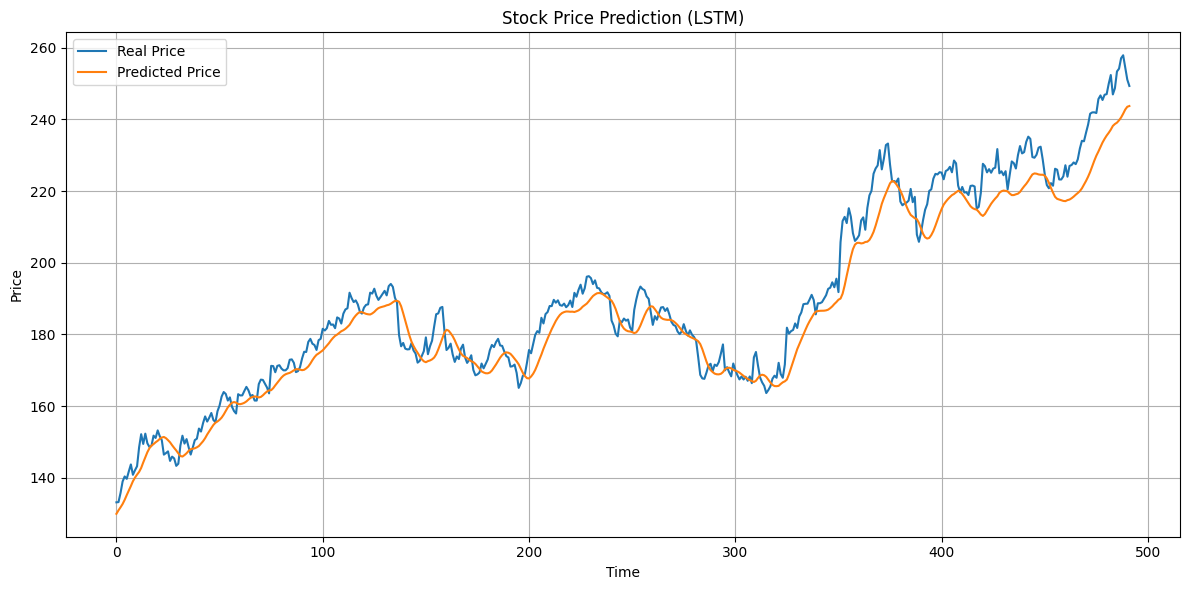

In [90]:
plot_predictions(real_prices,predicted_prices)